In [2]:
from scipy import *
import numpy as np
import WLanalysis
from matplotlib import pyplot
import emcee
import corner

In [94]:
colors=['r','b','c']
proxy=[plt.Rectangle((0,0),1,0.5,ec=icolor, fc = icolor) for icolor in colors]
colors2=['c','y','r','b']
proxy2=[plt.Rectangle((0,0),1,0.5,ec=icolor, fc = icolor) for icolor in colors2]

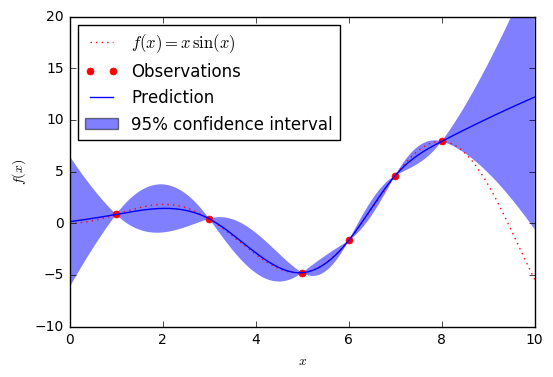

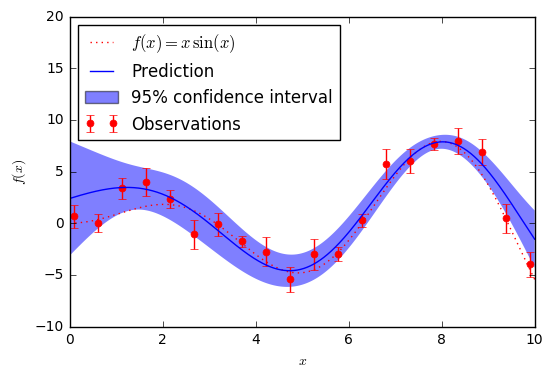

In [3]:
#import sklearn
from sklearn import gaussian_process
from sklearn.gaussian_process import GaussianProcess
# from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from matplotlib import pyplot as pl

np.random.seed(1)


def f(x):
    """The function to predict."""
    return x * np.sin(x)

#----------------------------------------------------------------------
#  First the noiseless case
X = np.atleast_2d([1., 3., 5., 6., 7., 8.]).T

# Observations
y = f(X).ravel()

# Mesh the input space for evaluations of the real function, the prediction and
# its MSE
x = np.atleast_2d(np.linspace(0, 10, 1000)).T

# Instanciate a Gaussian Process model
gp = GaussianProcess(corr='cubic', theta0=1e-2, thetaL=1e-4, thetaU=1e-1,
                     random_start=100)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, MSE = gp.predict(x, eval_MSE=True)
sigma = np.sqrt(MSE)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
fig = pl.figure()
pl.plot(x, f(x), 'r:', label=u'$f(x) = x\,\sin(x)$')
pl.plot(X, y, 'r.', markersize=10, label=u'Observations')
pl.plot(x, y_pred, 'b-', label=u'Prediction')
pl.fill(np.concatenate([x, x[::-1]]),
        np.concatenate([y_pred - 1.9600 * sigma,
                       (y_pred + 1.9600 * sigma)[::-1]]),
        alpha=.5, fc='b', ec='None', label='95% confidence interval')
pl.xlabel('$x$')
pl.ylabel('$f(x)$')
pl.ylim(-10, 20)
pl.legend(loc='upper left')

#----------------------------------------------------------------------
# now the noisy case
X = np.linspace(0.1, 9.9, 20)
X = np.atleast_2d(X).T

# Observations and noise
y = f(X).ravel()
dy = 0.5 + 1.0 * np.random.random(y.shape)
noise = np.random.normal(0, dy)
y += noise

# Mesh the input space for evaluations of the real function, the prediction and
# its MSE
x = np.atleast_2d(np.linspace(0, 10, 1000)).T

# Instanciate a Gaussian Process model
gp = GaussianProcess(corr='squared_exponential', theta0=1e-1,
                     thetaL=1e-3, thetaU=1,
                     nugget=(dy / y) ** 2,
                     random_start=100)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, MSE = gp.predict(x, eval_MSE=True)
sigma = np.sqrt(MSE)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
fig = pl.figure()
pl.plot(x, f(x), 'r:', label=u'$f(x) = x\,\sin(x)$')
pl.errorbar(X.ravel(), y, dy, fmt='r.', markersize=10, label=u'Observations')
pl.plot(x, y_pred, 'b-', label=u'Prediction')
pl.fill(np.concatenate([x, x[::-1]]),
        np.concatenate([y_pred - 1.9600 * sigma,
                       (y_pred + 1.9600 * sigma)[::-1]]),
        alpha=.5, fc='b', ec='None', label='95% confidence interval')
pl.xlabel('$x$')
pl.ylabel('$f(x)$')
pl.ylim(-10, 20)
pl.legend(loc='upper left')

pl.show()

In [4]:
Ngrid = 50
param_range = [[0,0.35],[0.28, 0.32],[1.9,2.3]]

In [5]:
def plane_margin (chi2cube,Ngrid=Ngrid,x=23):
    prob = exp(-0.5*chi2cube).reshape(Ngrid, Ngrid, Ngrid)
    prob /= sum(prob[~isnan(prob)])
    return [sum(prob,axis=i) for i in range(3)]
    #return prob[x],prob[:,x],prob[:,:,x]

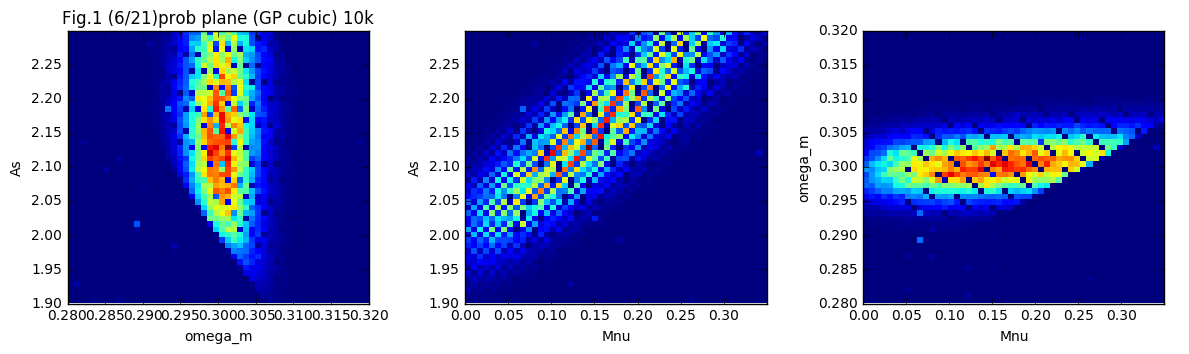

In [8]:
Nk = '10k'
Chi2_arr = load('/Users/jia/Dropbox/weaklensing/PDF/likelihood/prob/prob_{0}_N{1}_2stats_GP.npy'.format(Nk, Ngrid)).T

#for ix in range(50):
ix=23
f,axes=subplots(1,3,figsize=(12,3.5))
extents = ([param_range[1],param_range[2]],[param_range[0],param_range[2]],[param_range[0],param_range[1]])
labeles0 = ('Mnu','omega_m','As')
labels = ([labeles0[1],labeles0[2]],[labeles0[0],labeles0[2]],[labeles0[0],labeles0[1]])
i=0
for iP in plane_margin (Chi2_arr[0],x=ix):
    axes[i].imshow(iP.T,origin='lower',extent= array(extents[i]).flatten(),aspect='auto',interpolation='nearest')
    axes[i].set_xlabel(labels[i][0])
    axes[i].set_ylabel(labels[i][1])
    i+=1
plt.tight_layout()
axes[0].set_title('Fig.1 (6/21)prob plane (GP cubic) '+Nk)
# savefig('likelihood/testps_%i.jpg'%(ix))
# close()
show()

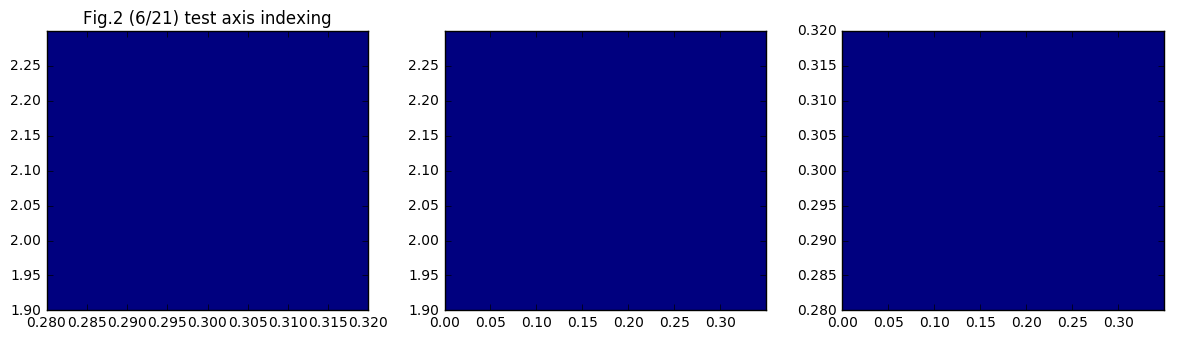

In [9]:
Ngrid =50 
param_range = [[0,0.35],[0.28, 0.32],[1.9,2.3]]
param_arr = [linspace(param_range[i][0],param_range[i][1],Ngrid) for i in range(3)]
param_list = array(meshgrid(param_arr[0],param_arr[1],param_arr[2],indexing='ij')).reshape(3,-1).T

f,axes=subplots(1,3,figsize=(12,3.5))
i=0
for iP in param_list.T:
    x=mean(iP.reshape(Ngrid, Ngrid, Ngrid),axis=i)
    axes[i].imshow(x,origin='lower',extent= array(extents[i]).flatten(),aspect='auto')
    i+=1
axes[0].set_title('Fig.2 (6/21) test axis indexing')
plt.tight_layout()
show()

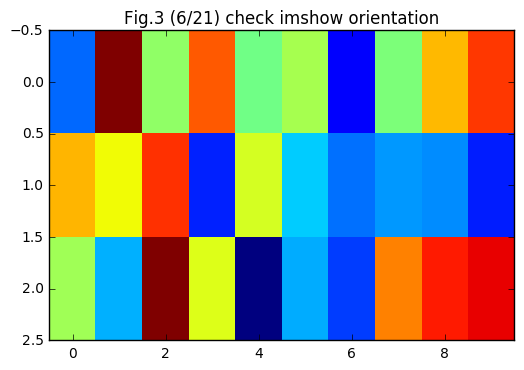

In [10]:
imshow(rand(3,10),aspect='auto',interpolation='nearest')
title('Fig.3 (6/21) check imshow orientation')
show()

In [424]:
############ test GP #########
from scipy import *
import numpy as np
import WLanalysis
from emcee.utils import MPIPool 
import sys, itertools

Nk='10k' # '5ka', '5kb'
Ngrid = 50
Nmin=5
z_arr = arange(0.5,3,0.5)
Nz = len(z_arr)
#####################################
######## set up folders #############
#####################################

######## stampede2
stats_dir = '/scratch/02977/jialiu/peakaboo/'
ebcov_dir = stats_dir+'stats/Om0.29997_As2.10000_mva0.00000_mvb0.00000_mvc0.00000_h0.70000_Ode0.69995/1024b512/box5/output_eb_5000_s4/seed0/'

    
######### local
stats_dir = '/Users/jia/Dropbox/weaklensing/PDF/'
ebcov_dir = stats_dir+'box5/'#output_eb_5000_s4/seed0/'

eb_dir = stats_dir+'stats_avg/output_eb_5000_s4/'
eb1k_dir = stats_dir+'stats_avg_1k/output_eb_5000_s4/'

#####################################
##### initiate avg statistics #######
#####################################

###### PS shape:(5, 101, 20)
psI = array( [load(eb_dir+'ALL_igalXigal_z{0}_z{1}_{2}.npy'.format(z_arr[i],z_arr[j],Nk))
              for i in range(Nz) for j in range(i,Nz)])
# auto's only
psIauto = array( [load(eb_dir+'ALL_igalXigal_z{0}_z{0}_{1}.npy'.format(iz,Nk)) for iz in z_arr])


##### 1d PDF shape:(5, 101, 27)
pdf1dN = array( [load(eb_dir+'ALL_gal_pdf_z{0}_sg1.0_{1}.npy'.format(iz,Nk)) for iz in z_arr])


#### 2d PDF shape:(10, 101, 27, 27)
# pdf2dN = array( [load(eb_dir+'ALL_galXgal_2dpdf_z{0}_z{1}_sg1.0_{2}.npy'.format(z_arr[i],z_arr[j],Nk)) 
#                  for i in range(Nz) for j in range(i+1,Nz)])

#####################################
###### covariances stats ############
#####################################

##### PS shape:(101,100)
psI_flat = swapaxes(psI,0,1).reshape(101,-1) 
psIauto = array( [load(eb_dir+'ALL_igalXigal_z{0}_z{0}_{1}.npy'.format(iz,Nk)) for iz in z_arr])

psN_cov = swapaxes(array( [load(ebcov_dir+'ALL_galXgal_z{0}_z{0}.npy'.format(iz)) for iz in z_arr]),0,1).reshape(10000,-1)
covpsN = cov(psN_cov,rowvar=0)*12.25/2e4
covIpsN = mat(covpsN).I

###### PDF 1D
idxt=where(pdf1dN[:,1]>Nmin)#range(10, 20)#

pdf1dN_flat= swapaxes(pdf1dN[idxt[0],:,idxt[1]],0,1).reshape(101,-1) 
# pdf1dN1k_flat = array([swapaxes(ips[idxt[0],:,idxt[1]],0,1).reshape(101,-1) for ips in pdf1dN1ks])

pdf1dN_cov = swapaxes(array( [load(ebcov_dir+'ALL_gal_pdf_z{0}_sg1.0.npy'.format(iz)) for iz in z_arr])[idxt[0],:,idxt[1]],0,1).reshape(10000,-1)
covpdf1dN = cov(pdf1dN_cov,rowvar=0)*12.25/2e4
covIpdf1dN = mat(covpdf1dN).I

###### PDF 2D
# idxt2=where(pdf2dN[:,1]>Nmin)

# pdf2dN_flat= swapaxes(pdf2dN,0,1)[:,idxt2[0],idxt2[1],idxt2[2]]
# # pdf2dN1k_flat= array([swapaxes(ips,0,1)[:,idxt2[0],idxt2[1],idxt2[2]] for ips in pdf2dN1ks])

# pdf2dN_cov = swapaxes(array( [load(ebcov_dir+'ALL_galXgal_2dpdf_z{0}_z{1}_sg1.0.npy'.format(z_arr[i],z_arr[j]))
#                              for i in range(Nz) for j in range(i+1,Nz)]),0,1)[:,idxt2[0],idxt2[1],idxt2[2]].reshape(10000,-1)

# covpdf2dN = cov(pdf2dN_cov,rowvar=0)*12.25/2e4
# covIpdf2dN = mat(covpdf2dN).I

#####################################
###### build emulator ###############
#####################################

params = genfromtxt(stats_dir+'cosmo_params_all.txt',usecols=[2,3,4])
fidu_params = array([0.1,0.3,2.1])

######## pick the good cosmology, where std/P among 10 1k models is <1%, and remove the first cosmology, 0eV one
# psI1k_std = std(psI1ks,axis=0)
# frac_diff = psI1k_std/psI[:,1].reshape(Nz,1,20)
# idx_good = where(amax(mean(frac_diff,axis=-1),axis=0)<0.01)[0][1:] 

############## test 6/23, use different IC for building emulator ########
#np.random.seed(10027)
#idx10 = list(np.random.randint(0,10, 101))
#stats = [array([istats[idx10[i],i] for i in range(101)]) for istats in [psI1k_flat, pdf1dN1k_flat, pdf2dN1k_flat]]
######################################
covgen = lambda psN_cov:cov(psN_cov,rowvar=0)*12.25/2e4
covIgen = lambda psN_cov:mat(cov(psN_cov,rowvar=0)*12.25/2e4).I
    
##### PS shape:(101,100)
psI_flat = swapaxes(psI,0,1).reshape(101,-1) 
psIauto_flat = swapaxes(psIauto,0,1).reshape(101,-1) 
#psI1k_flat = array([swapaxes(ips,0,1).reshape(101,-1) for ips in psI1ks])

psN_cov = swapaxes(array( [load(ebcov_dir+'ALL_galXgal_z{0}_z{1}.npy'.format(z_arr[i],z_arr[j]))
                           for i in range(Nz) for j in range(i,Nz)]),0,1).reshape(10000,-1)
covIpsN = covIgen(psN_cov)


psNauto_cov = swapaxes(array( [load(ebcov_dir+'ALL_galXgal_z{0}_z{0}.npy'.format(z_arr[i]))
                           for i in range(Nz)]),0,1).reshape(10000,-1)
covIpsNauto = covIgen(psNauto_cov)

###### PDF 1D
idxt=where(pdf1dN[:,5]>Nmin)

pdf1dN_flat= swapaxes(pdf1dN[idxt[0],:,idxt[1]],0,1).reshape(101,-1) 
##pdf1dN1k_flat = array([swapaxes(ips[idxt[0],:,idxt[1]],0,1).reshape(101,-1) for ips in pdf1dN1ks])

pdf1dN_cov = swapaxes(array( [load(ebcov_dir+'ALL_gal_pdf_z{0}_sg1.0.npy'.format(iz)) for iz in z_arr])[idxt[0],:,idxt[1]],0,1).reshape(10000,-1)
covIpdf1dN = covgen(pdf1dN_cov)

###### combined ps + pdf, for both auto and cross
comb_auto_flat = concatenate([psIauto_flat, pdf1dN_flat], axis=-1)
comb_cros_flat = concatenate([psI_flat, pdf1dN_flat], axis=-1)

comb_cov_auto = concatenate([psNauto_cov,pdf1dN_cov],axis=-1)
comb_cov_cros = concatenate([psN_cov,pdf1dN_cov],axis=-1)

covcomb_auto = covgen(comb_cov_auto)
covcomb_cros = covgen(comb_cov_cros)

covIcomb_auto = covIgen(comb_cov_auto)
covIcomb_cros = covIgen(comb_cov_cros)
#emulators = [WLanalysis.buildInterpolator(array(istats)[2:], params[2:]) for istats in stats]
print 'done'

done


In [425]:
print psI_flat.shape, psIauto_flat.shape, pdf1dN_flat.shape, comb_auto_flat.shape, comb_cros_flat.shape
print covIpsN.shape, covIpsNauto.shape, covIpdf1dN.shape, covcomb_auto.shape, covcomb_cros.shape

(101, 300) (101, 100) (101, 89) (101, 189) (101, 389)
(300, 300) (100, 100) (89, 89) (189, 189) (389, 389)


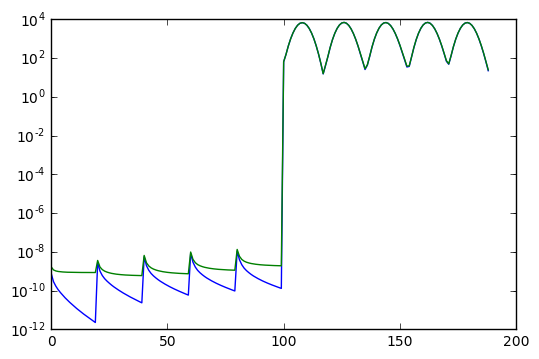

In [426]:
f,ax=subplots(1,1)
ax.plot (comb_auto_flat[1])
ax.plot (mean(comb_cov_auto,axis=0))
ax.set_yscale('log')
show()

In [427]:
############## test combined likelihood

fidu_params = array([0.1,0.3,2.1])

obss = [psIauto_flat[1], psI_flat[1], pdf1dN_flat[1], comb_auto_flat[1],comb_cros_flat[1]]
covIs = [covIpsNauto, covIpsN, covIpdf1dN, covIcomb_auto, covIcomb_cros]
rDH = [ float((1e4-len(covI)-2.0)/9999.0) for covI in covIs] ## 

#emulators = [WLanalysis.buildInterpolator(array(istats)[1:], params[1:], function='GP') 
#             for istats in [psIauto_flat, psI_flat, pdf1dN_flat, comb_auto_flat,comb_cros_flat]]
emusingle = [WLanalysis.buildInterpolator(array(istats)[2:], params[2:], function='GP') 
             for istats in [psIauto_flat, psI_flat,pdf1dN_flat]]
emucomb_auto = lambda p: concatenate([emusingle[0](p),emusingle[2](p)])
emucomb_cross = lambda p: concatenate([emusingle[1](p),emusingle[2](p)])
emulators= emusingle+[emucomb_auto,emucomb_cross]
emulators_comb=[WLanalysis.buildInterpolator(array(istats)[2:], params[2:], function='GP') 
            for istats in [comb_auto_flat,comb_cros_flat]]
             
            
#########
def lnprob(p,jjj):
    '''log likelihood of 
    '''
    if p[0]<0: ####### force neutrino mass to be positive
        return -np.inf
    diff = emulators[jjj](p)-obss[jjj]
    return float(-0.5*mat(diff)*covIs[jjj]*mat(diff).T)*rDH[jjj]


In [419]:
###### build a complete separate emulator
#emulator_ps = [WLanalysis.buildInterpolator(array(istats)[2:], params[2:], function='GP') for istats in psI]
#emulator_pdf = [WLanalysis.buildInterpolator(array(istats)[2:], params[2:], function='GP') for istats in pdf1dN]
# emulator_test = lambda p: concatenate([iemu(p) for iemu in emulator_ps+emulator_pdf])
# print psI.shape, pdf1dN.shape

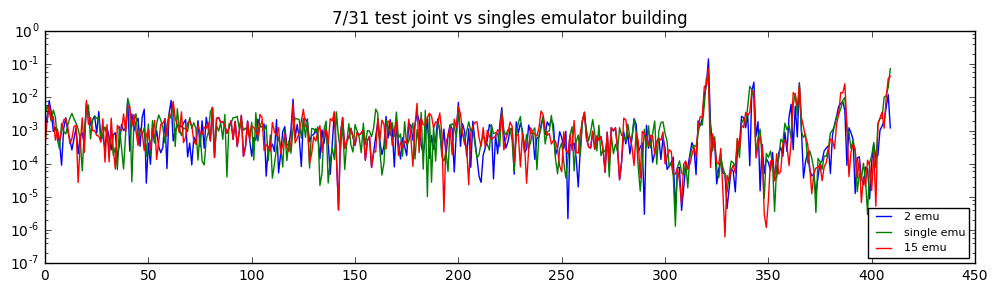

In [418]:
p=fidu_params
f,ax=subplots(1,1, figsize=(12,3))
ax.plot( abs(emucomb_cross(p)/obss[-1]-1),label='2 emu',lw=1)
ax.plot( abs(emulators_comb[1](p)/obss[-1]-1),label='single emu',lw=1)
ax.plot( abs(emulator_test(p)/obss[-1]-1),label='15 emu',lw=1)
ax.plot(zeros(len(obss[-1])),'k-')
ax.legend(fontsize=8,loc='lower right')
#ax.set_ylim(-0.01,0.01)
ax.set_yscale('log')
ax.set_title('7/31 test joint vs singles emulator building')
show()

In [428]:
stats_std = [std(istat,axis=0) for istat in (psNauto_cov, psN_cov, pdf1dN_cov, comb_cov_auto, comb_cov_cros)]
# for istd in stats_std:
#     print istd.shape

In [429]:
from scipy import stats#.kstest

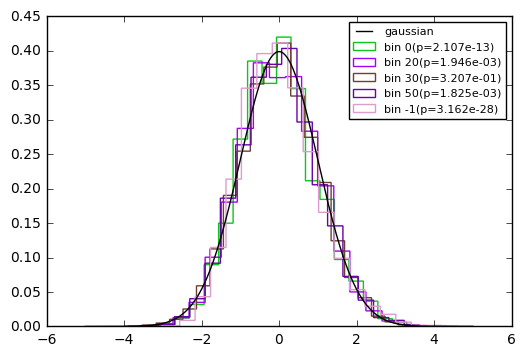

In [348]:
seed(34)
f,ax=subplots(1,1)
for i in (0,20,30,50,-1):
    icolor=rand(3)
    pdfnormed=(pdf1dN_cov[:,i]-mean(pdf1dN_cov[:,i]))/std(pdf1dN_cov[:,i])
    Pnorm=stats.kstest(pdfnormed,'norm')[1]
    #N=mean(pdf1dN_cov[:,i])
    ax.hist(pdfnormed,histtype='step',label='bin %i(p=%.3e)'%(i,Pnorm),bins=20,normed=1,color=icolor)
x=linspace(-5,5,1000)
y=1./sqrt(2*pi)*exp(-x**2/2.)

ax.plot(x,y,'k-',label='gaussian')
ax.legend(fontsize=8)
show()

In [436]:
p=fidu_params
lnprob_fidu = [lnprob(fidu_params,jjj) for jjj in range(5)]
def test_likelihood(p):
    print 'parameters', p
    print 'frac. diff\t diff/err \t lnprob\t lnprob-lnprob0'
    for jjj in range(5):
        diff = emulators[jjj](p)-obss[jjj]
        print '%.3e\t%.3e\t%f\t%f'%(mean(emulators[jjj](p)/obss[jjj]-1), 
                      mean((emulators[jjj](p)-obss[jjj])/(stats_std[jjj]/40.0)),
                      #sqrt(float(mat(diff)*covIs[jjj]*mat(diff).T)),
                       float(-0.5*mat(diff)*covIs[jjj]*mat(diff).T)*rDH[jjj],
                       float(-0.5*mat(diff)*covIs[jjj]*mat(diff).T)*rDH[jjj]-lnprob_fidu[jjj])
test_likelihood(p=fidu_params)
test_likelihood(p=fidu_params*1.01)
test_likelihood(p=fidu_params*1.00999999)

test_likelihood(p=fidu_params*0.99)

test_likelihood(p=fidu_params*1.02)
test_likelihood(p=fidu_params*0.98)

parameters [ 0.1  0.3  2.1]
frac. diff	 diff/err 	 lnprob	 lnprob-lnprob0
1.285e-04	6.651e-03	-1.354740	0.000000
6.599e-06	6.419e-03	-64.650361	0.000000
1.268e-04	1.428e-02	-52.692402	0.000000
1.277e-04	1.024e-02	-774.503576	0.000000
3.411e-05	8.217e-03	-684.780301	0.000000
parameters [ 0.101  0.303  2.121]
frac. diff	 diff/err 	 lnprob	 lnprob-lnprob0
4.823e-02	3.980e+00	-227.802354	-226.447615
4.808e-02	4.004e+00	-316.801267	-252.150906
1.252e-02	3.185e+00	-237474.001673	-237421.309271
3.141e-02	3.605e+00	-1074.906619	-300.403043
3.994e-02	3.817e+00	-1057.947317	-373.167016
parameters [ 0.101       0.303       2.12099998]
frac. diff	 diff/err 	 lnprob	 lnprob-lnprob0
4.789e-02	3.959e+00	-225.682514	-224.327774
4.812e-02	4.015e+00	-349.271806	-284.621445
1.254e-02	3.170e+00	-238059.805174	-238007.112772
3.124e-02	3.587e+00	-995.419152	-220.915577
3.998e-02	3.822e+00	-1050.383602	-365.603301
parameters [ 0.099  0.297  2.079]
frac. diff	 diff/err 	 lnprob	 lnprob-lnprob0
-4.704e-02	-3.8

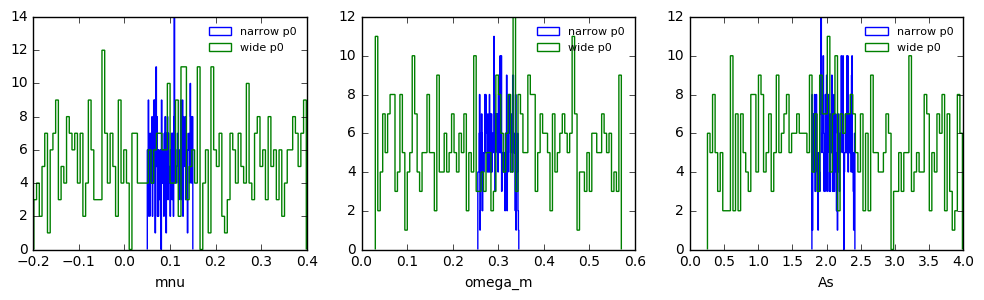

In [466]:
nwalkers=544
ndim=3
p0a = (array([ (rand(nwalkers, ndim) -0.5) * array([1, 0.3, 0.3]) + 1]) * fidu_params).reshape(-1,3)
p0 = (array([ (rand(nwalkers, ndim) -0.5) * 6 * array([1, 0.3, 0.3]) + 1]) * fidu_params).reshape(-1,3)

f,axes=subplots(1,3,figsize=(12,3))
for i in range(3):
    axes[i].hist(p0a.T[i],bins=100,histtype='step',label='narrow p0')
    axes[i].hist(p0.T[i],bins=100,histtype='step',label='wide p0')
    axes[i].set_xlabel(['mnu','omega_m','As'][i])
    axes[i].legend(fontsize=8, frameon=0)
show()

In [191]:
from matplotlib.colors import LogNorm

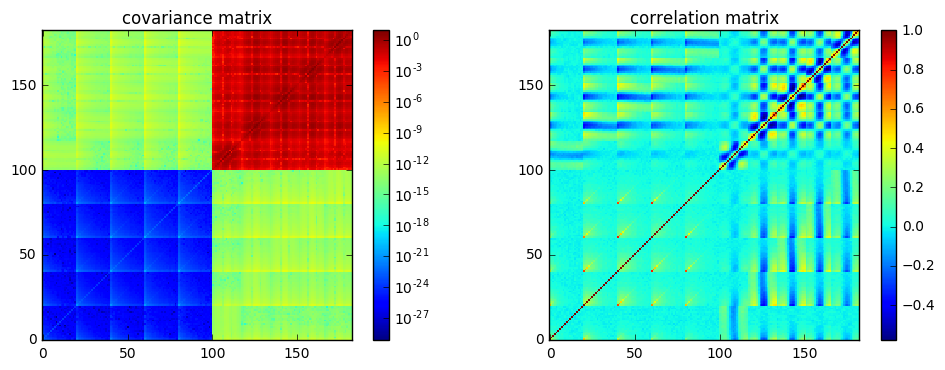

In [342]:
f,(ax1,ax2)=subplots(1,2,figsize=(12,4))
cb1=ax1.imshow(abs(covcomb_auto),origin='lower',interpolation='nearest',norm=LogNorm())
cb2=ax2.imshow(WLanalysis.corr_mat(covcomb_auto),origin='lower',interpolation='nearest')
f.colorbar(cb1,ax=ax1)
f.colorbar(cb2,ax=ax2)
ax1.set_title('covariance matrix')
ax2.set_title('correlation matrix')
show()

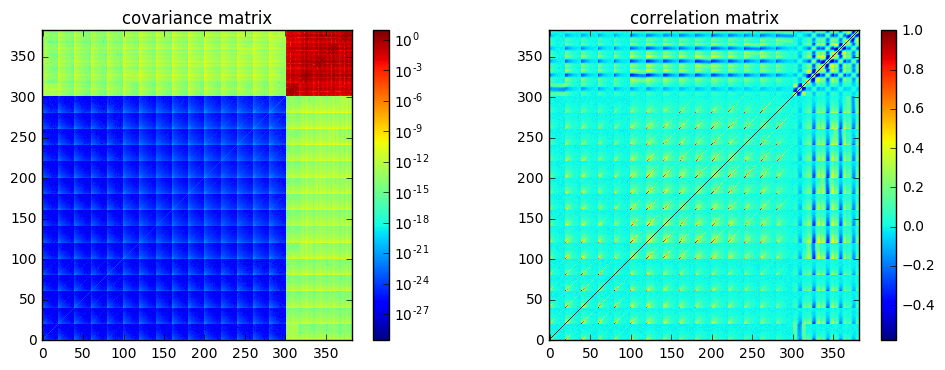

In [341]:
f,(ax1,ax2)=subplots(1,2,figsize=(12,4))
cb1=ax1.imshow(abs(covcomb_cros),origin='lower',interpolation='nearest',norm=LogNorm())
cb2=ax2.imshow(WLanalysis.corr_mat(covcomb_cros),origin='lower',interpolation='nearest')
f.colorbar(cb1,ax=ax1)
f.colorbar(cb2,ax=ax2)
ax1.set_title('covariance matrix')
ax2.set_title('correlation matrix')
show()

In [175]:
print covpdf1dN.shape,covpdf2dN.shape, pdf1dN.shape, pdf2dN.shape

(107, 107) (3760, 3760) (5, 101, 22) (10, 101, 22, 22)


In [154]:
x,y=params[2:],stats[0][2:]
#dy=stds[0][2:]
#print x.shape, y.shape, ((dy/y) ** 2).shape

In [155]:
test_rbf =  WLanalysis.buildInterpolator(y, x)
test_GP =  WLanalysis.buildInterpolator(y, x,function='GP')

In [20]:
%timeit test_rbf(fidu_params)#print y.shape,x.shape
%timeit test_GP(fidu_params)

100 loops, best of 3: 4.22 ms per loop
1000 loops, best of 3: 217 µs per loop


In [156]:
edge2center = lambda x: x[:-1]+0.5*(x[1:]-x[:-1])
ell_arr = range(100)#edge2center( linspace(100,5000,21))

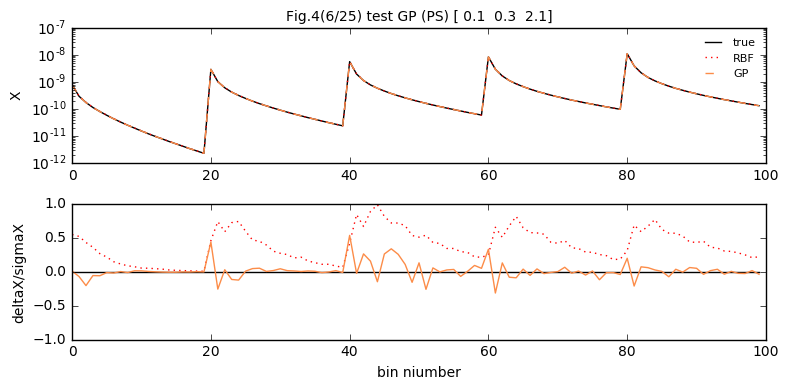

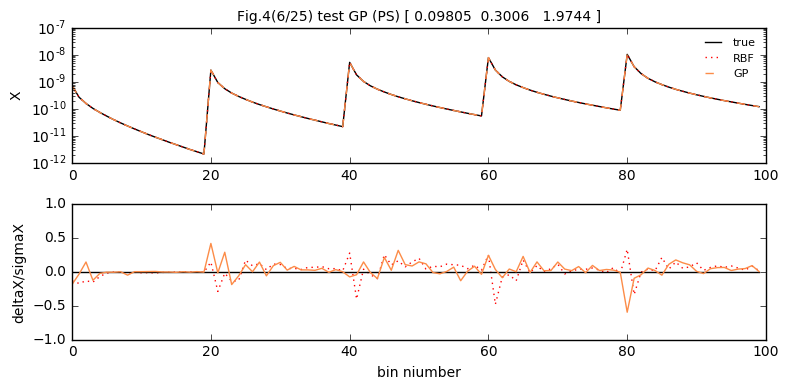

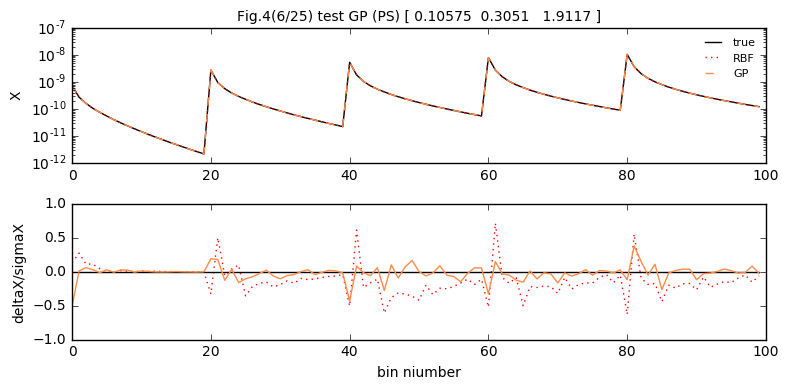

In [157]:
idxnear = where(  (params.T[0]>0.05) & (params.T[0]<0.3)
                & (params.T[1]>0.29) & (params.T[1]<0.31)
                & (params.T[2]>1.9) & (params.T[2]<2.3))[0]

j=0
istd=std([psN_cov,pdf1dN_cov,pdf2dN_cov][j],axis=0)*sqrt(12.25/1e4)
corr_arr = ['squared_exponential','absolute_exponential','cubic','linear']#'generalized_exponential',

for i in idxnear[:3]:
    seed(45)
    x,y = delete(params,(0,i),axis=0),delete(stats[j],(0,i),axis=0)
    ell_arr = arange(len(istd))
    
    test_rbf =  WLanalysis.buildInterpolator(y, x)
    ps_RBF = test_rbf (params[i])    

    f, (ax,ax2) = subplots(2,1,figsize=(8,4))
    ax.plot(ell_arr, stats[j][i],'k-',label='true')
    ax.plot(ell_arr, ps_RBF,'r:',label='RBF')
    
    ax.set_yscale('log')
    ax2.plot(ell_arr, (ps_RBF-stats[j][i])/istd,'r:')
    
    ax2.plot(ell_arr, zeros(len(ell_arr)),'k-')

    icolor=rand(3)
    test_gp = WLanalysis.buildInterpolator(y,x,function='GP')
    ps_GP = test_gp(params[i])
    ax.plot(ell_arr, ps_GP,'--',color=icolor,label='GP')
    ax2.plot(ell_arr, (ps_GP-stats[j][i])/istd,'-',color=icolor)

    ax2.set_ylim(-1,1)
    ax.legend(loc='best',fontsize=8,frameon=0)
    ax2.set_xlabel('bin niumber')
    ax.set_ylabel('X')
    ax2.set_ylabel('deltaX/sigmaX')
    ax.set_title('Fig.4(6/25) test GP (PS) %s'%(params[i]),fontsize=10)
    plt.tight_layout()
    show()
#     savefig('plots/testGP_%s_%i.jpg'%(['ps','pdf1d','pdf2d'][j],i))
#     close()

In [23]:
### try MCMC
stats = [psI_flat, pdf1dN_flat, pdf2dN_flat]
obss = [psI_flat[1], pdf1dN_flat[1], pdf2dN_flat[1]]
covIs = [covIpsN, covIpdf1dN]
j=0
x,y = delete(params,0,axis=0),delete(stats[j],0,axis=0)
test_gp = WLanalysis.buildInterpolator(y,x,function='GP')
interp_rbf = WLanalysis.buildInterpolator(y,x)
#ps_GP = test_gp(params[i])


In [24]:
# def lnprob(p,mu=obss[j],icov=covIs[j]):    
#     x=test_gp(p)
#     diff = x-mu
#     #print x.shape, mu.shape
#     return float(-0.5*mat(diff)*icov*mat(diff).T)
#print lnprob(fidu_params)

# means=obss[j]
# icov=covIs[j]
# print means.shape, icov.shape
# nwalkers = 250
# ndim=3

# p0 = ( array([ (rand(nwalkers, 3) -0.5) * array([1, 0.1, 0.1]) + 1]) * array(fidu_params) ).reshape(-1,3)

# sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[means, icov])

# pos, prob, state = sampler.run_mcmc(p0, 100)
# sampler.reset()
# sampler.run_mcmc(pos, 1000)

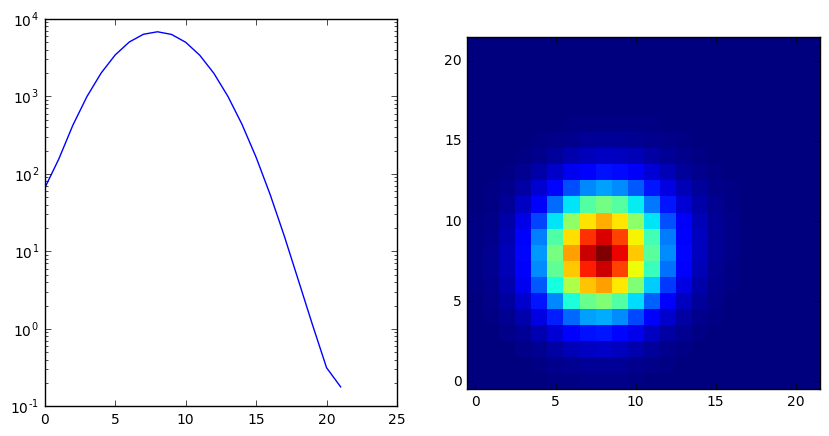

In [164]:
f, axes=subplots(1,2, figsize=(10,5))
axes[0].plot(pdf1dN[0,0])
axes[1].imshow(pdf2dN[0,0],origin=0,interpolation='nearest')
axes[0].set_yscale('log')
show()

In [120]:
def plothead (chain):
    f, axes = subplots(1,3,figsize=(10,3))
    axes[0].hist2d(chain.T[0], chain.T[1],bins=100)
    axes[1].hist2d(chain.T[0], chain.T[2],bins=100)
    axes[2].hist2d(chain.T[1], chain.T[2],bins=100)
    plt.tight_layout()
    show()

def plotmc(chain, f=None, icolor='k',range=[[-0.1,0.45],[0.28,0.32],[1.8,2.7]]):
    corner.corner(chain, labels=[r"$M_\nu$", r"$\Omega_m$", r"$A_s$"],levels=[0.67,0.95],color=icolor,
                  range=range,truths=fidu_params,
                  fig=f, plot_datapoints=0, plot_density=0, truth_color="k",fill_contours=1)

In [27]:
psarr=['ps','pdf1d','pdf2d']
Nkarr=['10k','5ka','5kb']
ips='ps'
MCps_arr = [load('likelihood/MC_ps_%stest.npy'%(Nk)) for Nk in Nkarr]
MC1d_arr = [load('likelihood/MC_pdf1d_%s.npy'%(Nk)) for Nk in Nkarr]
MC2d_arr = [load('likelihood/MC_pdf2d_%s.npy'%(Nk)) for Nk in Nkarr]

MC1d_arrb = [load('likelihood/MC_pdf1d_%stest.npy'%(Nk)) for Nk in Nkarr]
MC2d_arrb = [load('likelihood/MC_pdf2d_%stest.npy'%(Nk)) for Nk in Nkarr]

print MC1d_arrb[0].shape,MC1d_arr[0].shape
print MC2d_arrb[0].shape,MC2d_arr[0].shape

(125000, 3) (272000, 3)
(200000, 3) (1360000, 3)


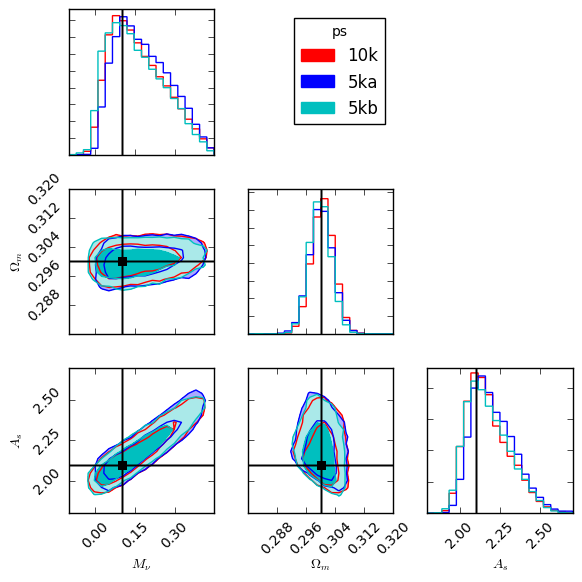

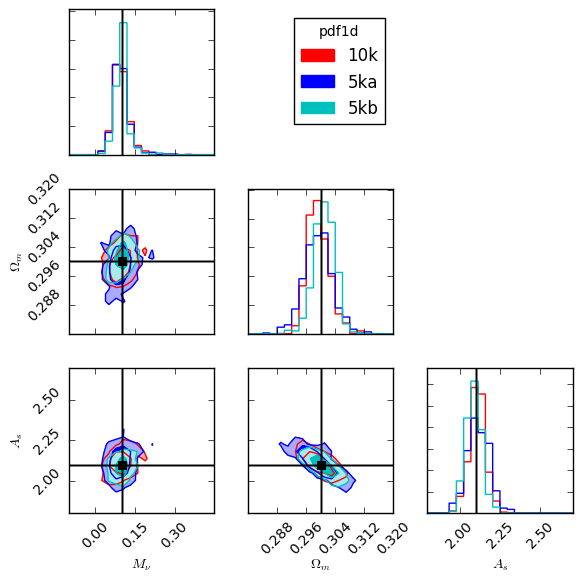

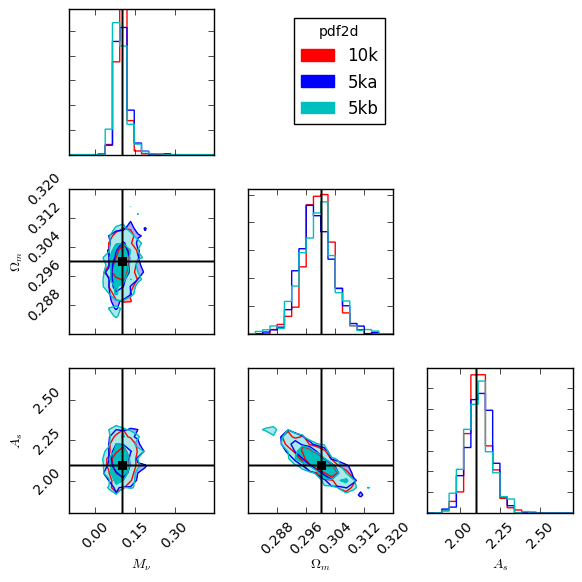

In [28]:

for j in range(3):
    f,ax=subplots(3,3,figsize=(6,6))
    for i in range(3):
        plotmc([MCps_arr,MC1d_arr, MC2d_arr][j][i],f=f,icolor=colors[i])
    ax[0,1].legend(proxy, Nkarr,title=psarr[j])
    plt.tight_layout()
    show()

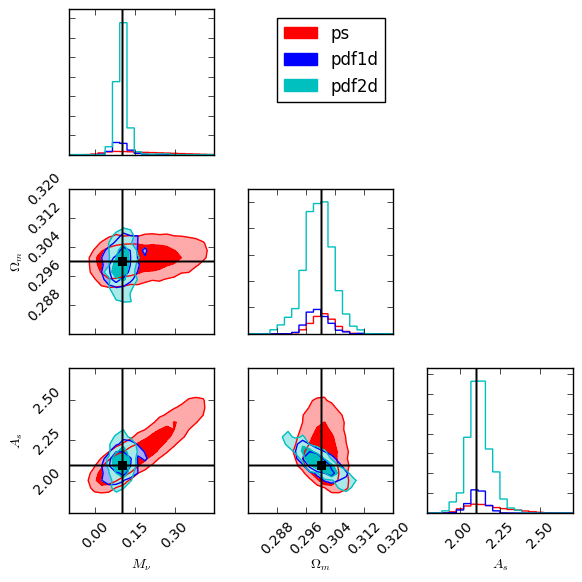

In [29]:
i=0
f,ax=subplots(3,3,figsize=(6,6))
for j in range(3):
    plotmc([MCps_arr[0],MC1d_arr[0], MC2d_arr[0]][j],f=f,icolor=colors[j])
ax[0,1].legend(proxy, psarr)
plt.tight_layout()
show()

In [165]:
############# try collapsed 1d pdf from 2d
pdf1dNb = array([sum(pdf2dN[i],axis=-1) for i in [0,4,7,9] ] + [sum(pdf2dN[-1],axis=-2)])
pdf1dNb.shape

(5, 101, 22)

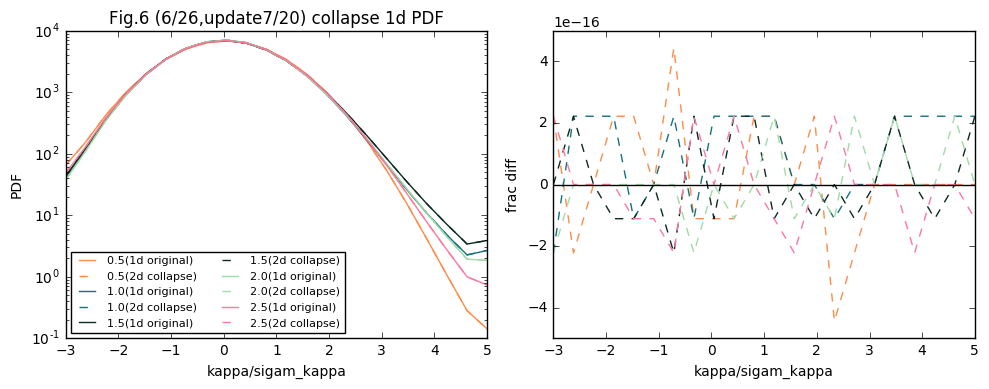

In [171]:
f, (ax,ax2)=subplots(1,2, figsize=(10,4))
seed(45)
kbins = linspace(-3,5,22)
for i in range(5):
    icolor=rand(3)
    ax.plot(kbins, pdf1dN[i][1],'-',color=icolor,label=str(z_arr[i])+'(1d original)')
    ax.plot(kbins, pdf1dNb[i][1],'--',color=icolor,label=str(z_arr[i])+'(2d collapse)')
    ax2.plot(kbins, pdf1dNb[i][1]/pdf1dN[i][1]-1,'--',color=icolor,label=str(z_arr[i])+'(2d collapse)')
ax.set_yscale('log')
ax.set_xlabel('kappa/sigam_kappa')
ax2.set_xlabel('kappa/sigam_kappa')
ax2.plot(kbins,zeros(len(kbins)),'k-')
#ax2.set_ylim(-0.01,0.01)
ax.set_ylabel('PDF')
ax2.set_ylabel('frac diff')
ax.legend(fontsize=8, ncol=2,loc='best')
ax.set_title('Fig.6 (6/26,update7/20) collapse 1d PDF')
plt.tight_layout()
show()

In [48]:
pdf2dN_cov.shape

(10000, 3396)

In [50]:
########## try to invert covariance matrix
idxt2=where(pdf2dN[:,1]>1e-3)
print idxt2[0].shape
                                                                       
# pdf2dN_cov = swapaxes(array( [load(ebcov_dir+'ALL_galXgal_2dpdf_z{0}_z{1}_sg1.0.npy'.format(z_arr[i],z_arr[j]))
#                              for i in range(Nz) for j in range(i+1,Nz)]),0,1)[:,idxt2[0],idxt2[1],idxt2[2]].reshape(10000,-1)

# covpdf2dN = cov(pdf2dN_cov,rowvar=0)*12.25/2e4
# covIpdf2dN = mat(covpdf2dN).I

(7033,)


/Users/jia/anaconda/lib/python2.7/site-packages/numpy/lib/scimath.py:310: RuntimeWarning: divide by zero encountered in log10
  return nx.log10(x)


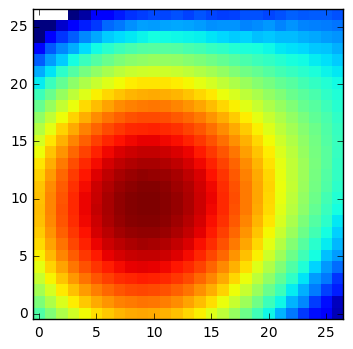

In [51]:
def process2dpdf(i,j):
    data=load(ebcov_dir+'ALL_galXgal_2dpdf_z{0}_z{1}_sg1.0.npy'.format(z_arr[i],z_arr[j]))
    return data

idata = mean(process2dpdf(0,1),axis=0)
idata.shape
imshow(log10(idata),interpolation='nearest',origin='lower')
show()

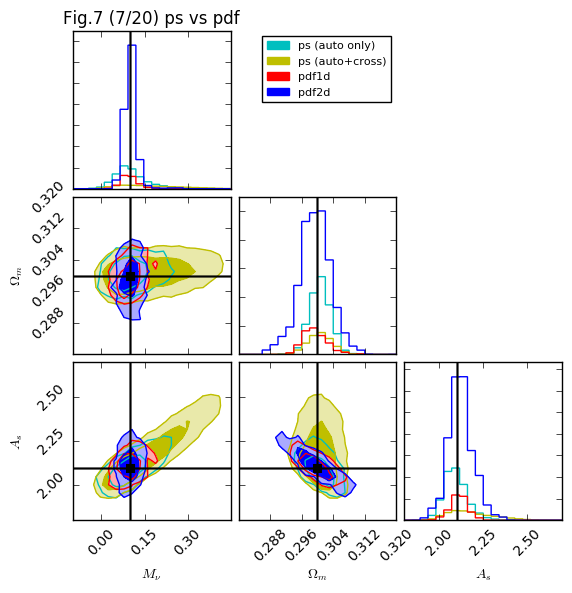

In [107]:
MC_Nmin_arr = [load('likelihood/MC_%s_10kNmin0.1cross.npy'%(ips)) for ips in psarr]
#MC_Nmin_arr = [MCps_arr[0]]+MC_Nmin_arr
MCall = [MC_Nmin_arr[0], MCps_arr[0], MC1d_arr[0], MC2d_arr[0]]
i=0
f,ax=subplots(3,3,figsize=(6,6))
for j in range(4):
    plotmc(MCall[j],f=f,icolor=colors2[j])
ax[0,1].legend(proxy2,['ps (auto only)','ps (auto+cross)','pdf1d','pdf2d'],fontsize=8)
ax[0,0].set_title('Fig.7 (7/20) ps vs pdf')
show()

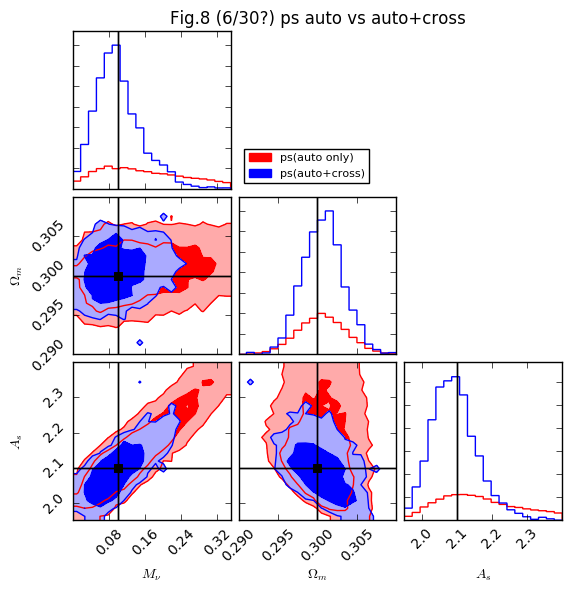

(250000, 3)


In [119]:
i=0
f,ax=subplots(3,3,figsize=(6,6))
for j in range(2):
    plotmc([MCps_arr[0], MC_Nmin_arr[0]][j],f=f,icolor=colors[j],
         range=[[0,.35],[.29,.31],[1.95,2.4]])
ax[0,1].legend(proxy[:-1],('ps(auto only)','ps(auto+cross)'),fontsize=8, loc='lower left')
ax[0,1].set_title('Fig.8 (6/30?) ps auto vs auto+cross')
show()
print MCps_arr[0].shape

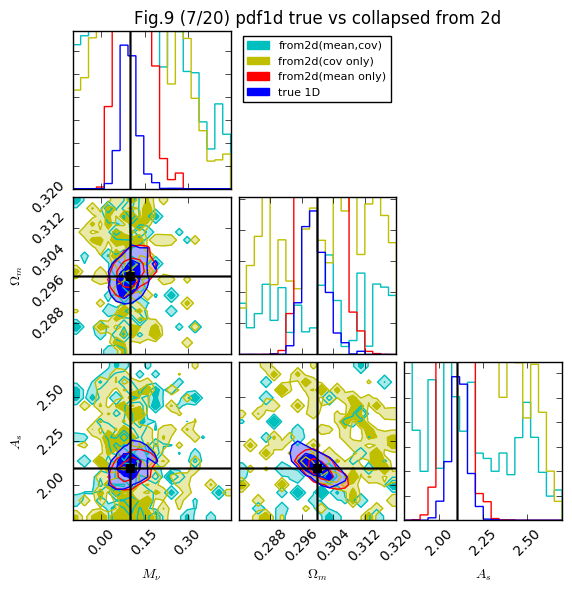

In [70]:
MC_ps1d_test = [load('likelihood/MC_pdf1d_10kcollapsed_%s.npy' % (itest)) [1000:] for itest in 
                ['mean_cov','cov_only','mean_only']]
i=0

f,ax=subplots(3,3,figsize=(6,6))
for j in arange(len(MC_ps1d_test)):
    plotmc(MC_ps1d_test[j],f=f,icolor=colors2[j],)
plotmc(MC1d_arr[0],f=f,icolor=colors2[j+1])
ax[0,1].legend(proxy2,['from2d(mean,cov)','from2d(cov only)','from2d(mean only)','true 1D'],fontsize=8)
ax[0,1].set_title('Fig.9 (7/20) pdf1d true vs collapsed from 2d')
show()

In [80]:
pdf1dN_cov2 = array([sum(load(ebcov_dir+'ALL_galXgal_2dpdf_z{0}_z{1}_sg1.0.npy'.format(z_arr[i],z_arr[i+1])),axis=-1) for i in range(4) ] + [sum(load(ebcov_dir+'ALL_galXgal_2dpdf_z2.0_z2.5_sg1.0.npy'),axis=-2)])[idxt[0],:,idxt[1]].T
covpdf1dN2 = cov(pdf1dN_cov2,rowvar=0)*12.25/2e4
covpdf1dN.shape,covpdf1dN.shape

((119, 119), (119, 119))

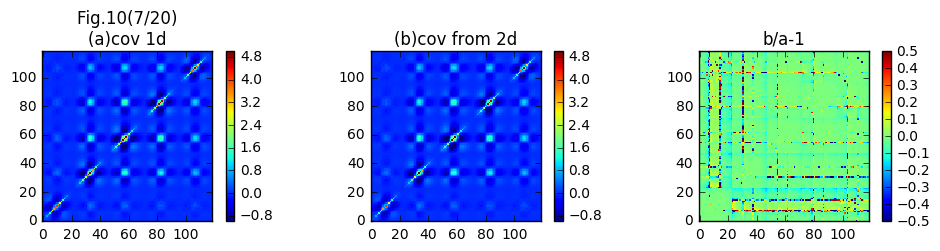

In [112]:
f,(ax1,ax2,ax3)=subplots(1,3,figsize=(10,2.5))
cb1=ax1.imshow(covpdf1dN,interpolation='nearest',origin='lower',vmin=-1,vmax=5)
cb2=ax2.imshow(covpdf1dN2,interpolation='nearest',origin='lower',vmin=-1,vmax=5)
cb3=ax3.imshow(covpdf1dN2/covpdf1dN-1,interpolation='nearest',origin='lower',vmin=-0.5,vmax=0.5)
f.colorbar(cb1,ax=ax1)
f.colorbar(cb2,ax=ax2)
f.colorbar(cb3,ax=ax3)
ax1.set_title('Fig.10(7/20)\n(a)cov 1d')
ax2.set_title('(b)cov from 2d')
ax3.set_title('b/a-1')
plt.tight_layout()
show()

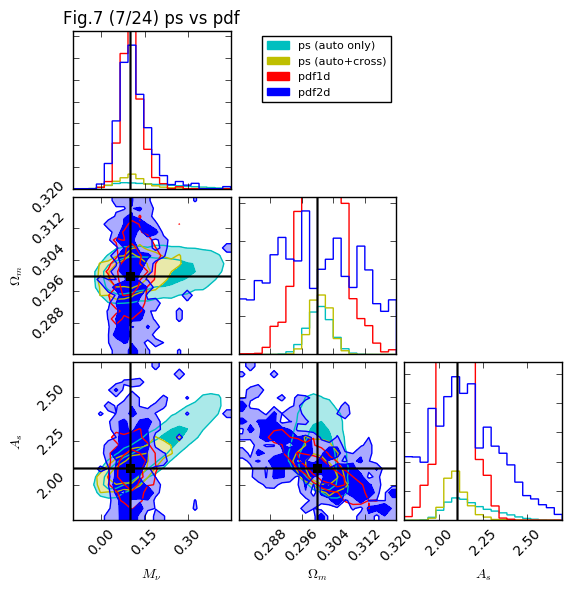

In [148]:
MC_jul24_arr = [load('likelihood/MC_jul24/MC_%s.npy'%(ips)) for ips in 
               ['ps_10kauto','ps_10k','pdf1d_10kNmin0.1R','pdf2d_10kNmin0.1R']]
i=0
f,ax=subplots(3,3,figsize=(6,6))
for j in range(4):
    plotmc(MC_jul24_arr[j],f=f,icolor=colors2[j])
ax[0,1].legend(proxy2,['ps (auto only)','ps (auto+cross)','pdf1d','pdf2d'],fontsize=8)
ax[0,0].set_title('Fig.7 (7/24) ps vs pdf')
show()

In [459]:
MC_aug1_narrow = [load('likelihood/MC_aug1/MC_%s_10k_Nmin5R_Nchain5000.npy'%(ips)) for ips in 
               ['psAuto','psCross','pdf1d','combAuto','combCross']]

MC_aug1_wide = [load('likelihood/MC_aug1/MC_%s_widerInitGuess6_R_Nmin5_Nchain5000_10k.npy'%(ips)) for ips in 
               ['psAuto','psCross','pdf1d','combAuto','combCross']]


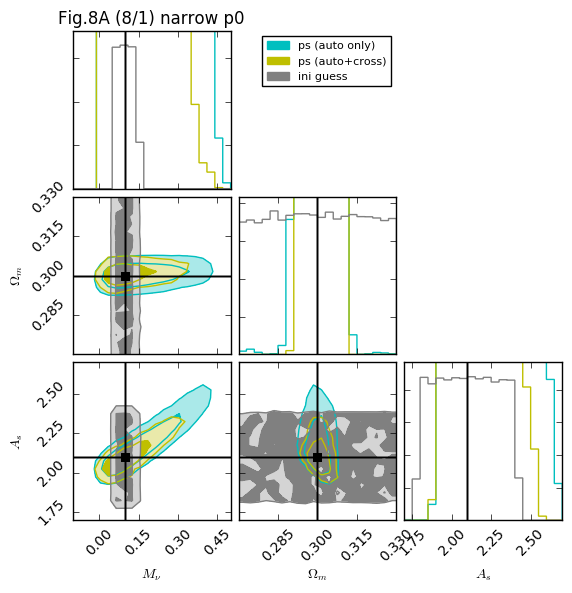

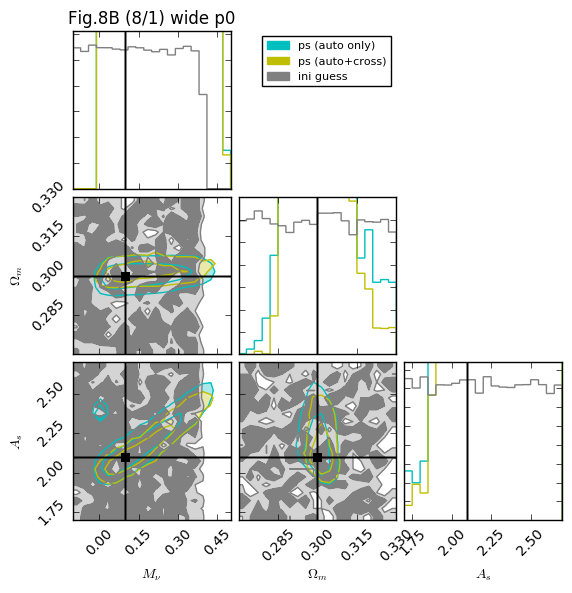

In [473]:
p0a = (array([ (rand(nwalkers*100, ndim) -0.5) * array([1, 0.3, 0.3]) + 1]) * fidu_params).reshape(-1,3)
p0 = (array([ (rand(nwalkers*100, ndim) -0.5) * 6 * array([1, 0.3, 0.3]) + 1]) * fidu_params).reshape(-1,3)

colors3=['c','y','grey']
proxy3=[plt.Rectangle((0,0),1,0.5,ec=icolor, fc = icolor) for icolor in colors3]

f,ax=subplots(3,3,figsize=(6,6))
for j in range(2):
    plotmc(MC_aug1_narrow[j][906666:],f=f,icolor=colors2[j],range=[[-0.1,0.5],[0.27,0.33],[1.7,2.7]])
plotmc(p0a,f=f,icolor='grey',range=[[-0.1,0.5],[0.27,0.33],[1.7,2.7]])
ax[0,1].legend(proxy3[:3],['ps (auto only)','ps (auto+cross)','ini guess'],fontsize=8)
ax[0,0].set_title('Fig.8A (8/1) narrow p0')
show()

f,ax=subplots(3,3,figsize=(6,6))
for j in range(2):
    plotmc(MC_aug1_wide[j][906666:],f=f,icolor=colors2[j],range=[[-0.1,0.5],[0.27,0.33],[1.7,2.7]])
plotmc(p0,f=f,icolor='grey',range=[[-0.1,0.5],[0.27,0.33],[1.7,2.7]])
ax[0,1].legend(proxy3[:3],['ps (auto only)','ps (auto+cross)','ini guess'],fontsize=8)
ax[0,0].set_title('Fig.8B (8/1) wide p0')
show()


In [463]:
MC_aug1_narrow[0].shape

(2720000, 3)

In [483]:
p0_ranges=array([[0,0.6],[0.25,0.35],[1.6,2.6]])
p0_ranges.shape
sample=rand(100,3)*(p0_ranges[:,1]-p0_ranges[:,0]).reshape(1,3)+p0_ranges[:,0].reshape(1,3)
print amin(sample,axis=0), amax(sample,axis=0)


[ 0.01044916  0.25010663  1.61436792] [ 0.5932705   0.34987309  2.59983446]
